# Scaled and Shifted Free-Space Propagation

In common free-space propagation methods (Fraunhofer, Fresnel, angular spectrum), we do not have control on the output plane sampling: the resolution, the sampling interval, the region-of-interest. In some cases, we may want to control the output plane sampling, e.g. to match the sampling of a detector.

In this notebook, we compare different approaches for doing rescaled free-space progation with the Fresnel approximation and the angular spectrum method (no approximation). We show how to specify different sampling parameters at the input and output planes. 

Bandlimited angular spectrum (BLAS) is generally prefered as it can be used for both near-field and far-field propagation. We compare the following approaches for scaled BLAS propagation:

1. ["Band-limited angular spectrum numerical propagation method with selective scaling of observation window size and sample number"](https://opg.optica.org/josaa/viewmedia.cfm?uri=josaa-29-11-2415&html=true) (Yu et al., 2012) 
2. Using the chirp Z-transform (CZT) to resample the angular spectrum, similar to ["Efficient full-path optical calculation of scalar and vector diffraction using the Bluestein method"](https://www.nature.com/articles/s41377-020-00362-z) (Hu et al., 2020)

Let's first define the setup, with all units in microns.

In [1]:
import time
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import chromatix.functional as cf

# import jax
# jax.config.update("jax_enable_x64", True)

shape = (1024, 1024)  # [px, px]
N_pad = (shape[0] // 2, shape[1] // 2)  # [px, px] padding to linearize the FFT
spectrum = 0.532  # wavelength [um]
dxi = 2 * spectrum
D = dxi * shape[0]  # field shape
w = D / 10  # width of aperture
z = 10 * D  # propagation distance
dxi = D / np.array(shape)
spacing = dxi[..., np.newaxis]
n = 1  # refractive index of medium
gpu_device = 0

print("Field shape [um]: ", D)
print("Width of aperture [um]: ", w)
print("Propagation distance [um]: ", z)

Field shape [um]:  1089.536
Width of aperture [um]:  108.95360000000001
Propagation distance [um]:  10895.36


Let's create a rectangular aperture at the input.

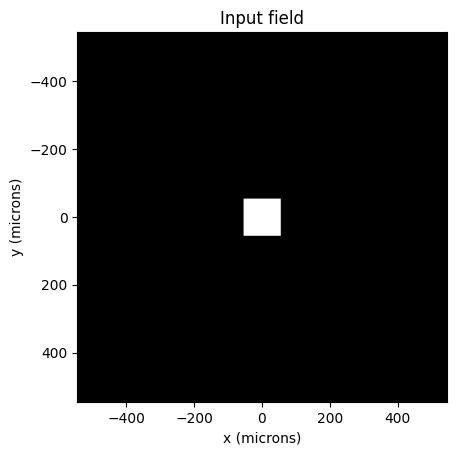

In [2]:
import jax
from jax import device_put

field = cf.plane_wave(
    shape=shape,
    dx=spacing,
    spectrum=spectrum,
    spectral_density=1.0,
    pupil=partial(cf.square_pupil, w=w),
)
field = device_put(field, jax.devices()[gpu_device])
plt.imshow(
    field.amplitude.squeeze(),
    cmap="gray",
    extent=[
        -D / 2,
        D / 2,  # x-axis
        D / 2,
        -D / 2,
    ],  # y-axis
)
plt.title("Input field")
plt.ylabel("y (microns)")
plt.xlabel("x (microns)");

Let's propagate with bandlimited angular spectrum (no scaling for now).

Time taken:  1.5275111198425293
Output field dtype:  float32
Output field shape:  (1024, 1024)


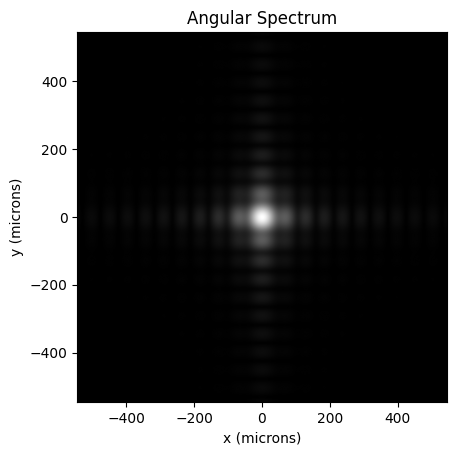

In [3]:
# Angular spectrum (bandlimited)
start_time = time.time()
out_field_blas = cf.asm_propagate(field, z, n, N_pad=N_pad, mode="same", bandlimit=True)
print("Time taken: ", time.time() - start_time)
u_blas = out_field_blas.amplitude.squeeze()
print("Output field dtype: ", u_blas.dtype)
print("Output field shape: ", u_blas.shape)

fig, axs = plt.subplots(1, 1)
axs.imshow(u_blas, cmap="gray", extent=[-D / 2, D / 2, -D / 2, D / 2])
axs.set_title("Angular Spectrum")
axs.set_ylabel("y (microns)")
axs.set_xlabel("x (microns)");

Let's zoom into to a specific region of interest.

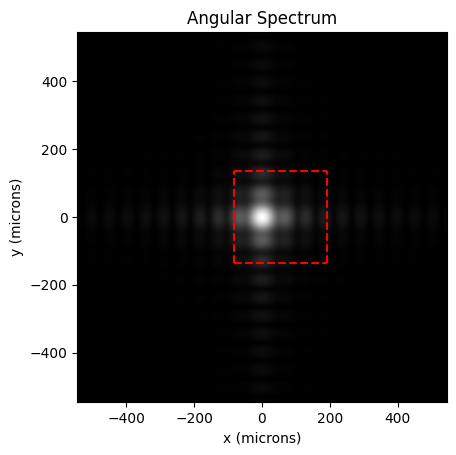

In [4]:
from chromatix.utils import bounding_box

zoom_factor = 4
shift_yx = [0, w / 2]

fig, axs = plt.subplots(1, 1)
axs.imshow(u_blas, cmap="gray", extent=[-D / 2, D / 2, -D / 2, D / 2])
axs.set_title("Angular Spectrum")
axs.set_ylabel("y (microns)")
axs.set_xlabel("x (microns)")

y_bounds, x_bounds = field.spatial_limits
x_bounds = [
    x_bounds[0] / zoom_factor + shift_yx[1],
    x_bounds[1] / zoom_factor + shift_yx[1],
]
y_bounds = [
    y_bounds[0] / zoom_factor + shift_yx[0],
    y_bounds[1] / zoom_factor + shift_yx[0],
]
bounding_box(
    ax=axs,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    c="r",
    linestyle="--",
    surface_area=field.surface_area.squeeze(),
)

The naive approach for zooming into this region (while maintaining the resolution / sampling period) would be to increase the resolution of the input field. However, this may require large memory and computation requirements.

Input field shape :  (4096, 4096)
Computation time: 5.58 s
Output field dtype:  float32
Output field shape :  (4096, 4096)


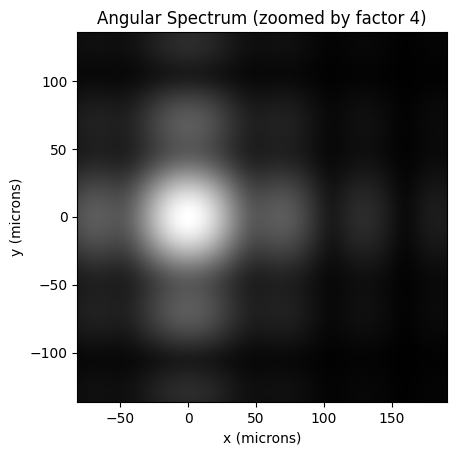

In [5]:
# for similar resolution as zoom need to increase resolution
shape_hi_res = (shape[0] * zoom_factor, shape[1] * zoom_factor)
spacing_hi_res = dxi / zoom_factor
spacing_hi_res = spacing_hi_res[..., np.newaxis]
N_pad_hi_res = (shape_hi_res[0] // 2, shape_hi_res[1] // 2)

field_hi_res = cf.plane_wave(
    shape=shape_hi_res,
    dx=spacing_hi_res,
    spectrum=spectrum,
    spectral_density=1.0,
    pupil=partial(cf.square_pupil, w=w),
)
field_hi_res = device_put(field_hi_res, jax.devices()[gpu_device])
print("Input field shape : ", field_hi_res.amplitude.squeeze().shape)

# Angular spectrum (bandlimited)
start_time = time.time()
out_field_blas_hires = cf.asm_propagate(
    field_hi_res, z, n, N_pad=N_pad_hi_res, mode="same", bandlimit=True
)
u_blas = out_field_blas_hires.amplitude.squeeze()
print(f"Computation time: {time.time() - start_time:.2f} s")
print("Output field dtype: ", u_blas.dtype)
print("Output field shape : ", u_blas.shape)

fig, axs = plt.subplots(1, 1)
axs.imshow(u_blas, cmap="gray", extent=[-D / 2, D / 2, -D / 2, D / 2])
axs.set_xlim(x_bounds[0], x_bounds[1])
axs.set_ylim(y_bounds[0], y_bounds[1])
axs.set_title(f"Angular Spectrum (zoomed by factor {zoom_factor})")
axs.set_ylabel("y (microns)")
axs.set_xlabel("x (microns)");

That's significantly more compute time, and it would only get worse if we need to zoom in further.

### 1) "Band-limited angular spectrum numerical propagation method with selective scaling of observation window size and sample number" (Yu et al., 2012)  

Below we apply the technique suggested by [Yu et al.](https://opg.optica.org/josaa/fulltext.cfm?uri=josaa-29-11-2415&id=244612) in 2012.

Computation time: 0.81 s
Output field dtype:  float32
Output field shape :  (1024, 1024)
Output field norm :  3.1434317


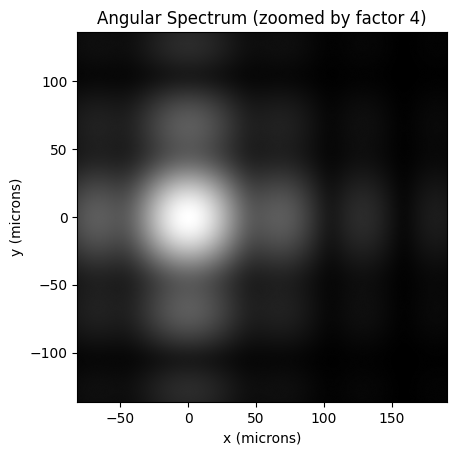

In [6]:
start_time = time.time()
out_field_blas_scaled = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    # adjust spacing to zoom in
    dx=spacing / zoom_factor,
    shift_yx=shift_yx,
)
print(f"Computation time: {time.time() - start_time:.2f} s")
u_blas_scaled = out_field_blas_scaled.amplitude.squeeze()
print("Output field dtype: ", u_blas_scaled.dtype)
print("Output field shape : ", u_blas_scaled.shape)
print("Output field norm : ", np.linalg.norm(u_blas_scaled))

D_out = D / zoom_factor
fig, axs = plt.subplots(1, 1)
axs.imshow(
    u_blas_scaled,
    cmap="gray",
    extent=[
        -D_out / 2 + shift_yx[1],
        D_out / 2 + shift_yx[1],
        -D_out / 2 + shift_yx[0],
        D_out / 2 + shift_yx[0],
    ],
)
axs.set_title(f"Angular Spectrum (zoomed by factor {zoom_factor})")
axs.set_ylabel("y (microns)")
axs.set_xlabel("x (microns)");

### 2) Based on the Chirp Z-transform (CZT)

Below we apply a technique based on the Chirp Z-transform, similar to the one suggested by [Hu et al.](https://www.nature.com/articles/s41377-020-00362-z) in 2020.

Computation time: 1.76 s
Output field dtype:  float32
Output field shape :  (1024, 1024)
Output field norm :  44.409435


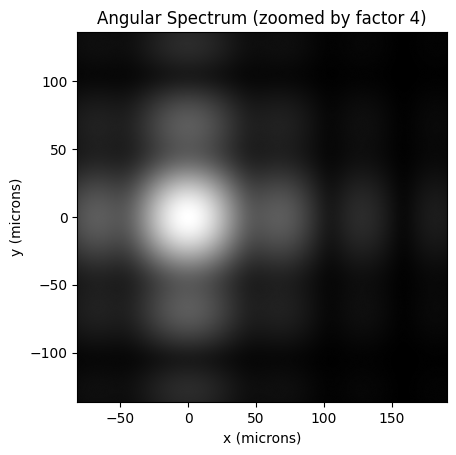

In [7]:
start_time = time.time()
out_field_blas_scaled = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    # adjust spacing to zoom in
    dx=spacing / zoom_factor,
    shift_yx=shift_yx,
    use_czt=True,
)
print(f"Computation time: {time.time() - start_time:.2f} s")
u_blas_scaled = out_field_blas_scaled.amplitude.squeeze()
print("Output field dtype: ", u_blas_scaled.dtype)
print("Output field shape : ", u_blas_scaled.shape)
print("Output field norm : ", np.linalg.norm(u_blas_scaled))

D_out = D / zoom_factor
fig, axs = plt.subplots(1, 1)
axs.imshow(
    u_blas_scaled,
    cmap="gray",
    extent=[
        -D_out / 2 + shift_yx[1],
        D_out / 2 + shift_yx[1],
        -D_out / 2 + shift_yx[0],
        D_out / 2 + shift_yx[0],
    ],
)
axs.set_title(f"Angular Spectrum (zoomed by factor {zoom_factor})")
axs.set_ylabel("y (microns)")
axs.set_xlabel("x (microns)");

We can also apply shifted and scaled free-space propagation with the **Fresnel approximation**. Note that this approximates the wavefront as parabolic (instead of spherical).

We can notice aliasing artifacts with Fresnel propagation when rescaling.

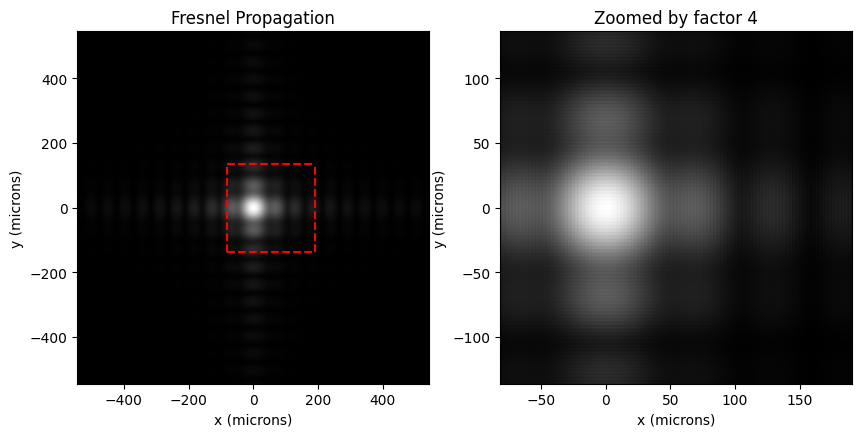

In [21]:
## ORIGINAL SIZE
out_field_fresnel = cf.transfer_propagate(field, z, n, N_pad=N_pad, mode="same")
u_fresnel = out_field_fresnel.amplitude.squeeze()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(u_fresnel, cmap="gray", extent=[-D / 2, D / 2, -D / 2, D / 2])
axs[0].set_title("Fresnel Propagation")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
bounding_box(
    ax=axs[0],
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    c="r",
    linestyle="--",
    surface_area=field.surface_area.squeeze(),
)

## RESCALED
out_field_fresnel_scaled = cf.transfer_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    # adjust spacing to zoom in
    dx=spacing / zoom_factor,
    shift_yx=shift_yx,
)
u_fresnel_scaled = out_field_fresnel_scaled.amplitude.squeeze()

D_out = D / zoom_factor
axs[1].imshow(
    u_fresnel_scaled,
    cmap="gray",
    extent=[
        -D_out / 2 + shift_yx[1],
        D_out / 2 + shift_yx[1],
        -D_out / 2 + shift_yx[0],
        D_out / 2 + shift_yx[0],
    ],
)
axs[1].set_title(f"Zoomed by factor {zoom_factor}")
axs[1].set_ylabel("y (microns)")
axs[1].set_xlabel("x (microns)");

### PROFILING

Below we compare the compute time.

In [9]:
n_trials = 10

# Propating larger fields
start_time = time.time()
blas_hi_res = cf.asm_propagate(
    field_hi_res, z, n, N_pad=N_pad_hi_res, mode="same", bandlimit=True
)
for _ in range(n_trials):
    cf.asm_propagate(
        field_hi_res, z, n, N_pad=N_pad_hi_res, mode="same", bandlimit=True
    )
blas_hir_res = (time.time() - start_time) / n_trials
print("-- BLAS hi-res: ", blas_hir_res)

# Yu et al. - https://opg.optica.org/josaa/fulltext.cfm?uri=josaa-29-11-2415&id=244612
start_time = time.time()
yu_et_al_result = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    dx=spacing / zoom_factor,
    shift_yx=shift_yx,
)
for _ in range(n_trials):
    cf.asm_propagate(
        field,
        z,
        n,
        N_pad=N_pad,
        mode="same",
        bandlimit=True,
        dx=spacing / zoom_factor,
        shift_yx=shift_yx,
    )
yu_et_al = (time.time() - start_time) / n_trials
print("-- Yu et al : ", yu_et_al)

# CZT based - https://www.nature.com/articles/s41377-020-00362-z
start_time = time.time()
czt_result = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    dx=spacing / zoom_factor,
    shift_yx=shift_yx,
    use_czt=True,
)
for _ in range(n_trials):
    cf.asm_propagate(
        field,
        z,
        n,
        N_pad=N_pad,
        mode="same",
        bandlimit=True,
        dx=spacing / zoom_factor,
        shift_yx=shift_yx,
        use_czt=True,
    )
czt_approach = (time.time() - start_time) / n_trials
print("-- CZT approach : ", czt_approach)

print("\nCZT speed-up (wrt hi-res BLAS)", blas_hir_res / czt_approach)
print("CZT speed-up (wrt Yu et al.)", yu_et_al / czt_approach)

-- BLAS hi-res:  6.209975337982177
-- Yu et al :  1.1306262969970704
-- CZT approach :  0.4798129081726074

CZT speed-up (wrt hi-res BLAS) 12.94249327645893
CZT speed-up (wrt Yu et al.) 2.356389913108257


In [10]:
# compare results
# -- element-wise comparison
np.allclose(
    yu_et_al_result.amplitude / np.linalg.norm(yu_et_al_result.amplitude),
    czt_result.amplitude / np.linalg.norm(czt_result.amplitude),
    atol=1e-4,
)
# - normalized root mean square error
h1 = yu_et_al_result.amplitude / np.linalg.norm(yu_et_al_result.amplitude)
h2 = czt_result.amplitude / np.linalg.norm(czt_result.amplitude)
np.sqrt(np.mean((h1 - h2) ** 2))

np.float32(7.4845457e-06)